<a href="https://colab.research.google.com/github/GuptaNavdeep1983/CS767/blob/main/767_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random


In [17]:
df = pd.read_csv("./Assignment_3_Hitters.csv")
df.rename( columns={'Unnamed: 0':'hitter_name'}, inplace=True )

# convert categorical values using one hot encoding
df = pd.get_dummies(df, columns=['League', 'Division', 'NewLeague'], prefix=["League_is", "Division_is", "NewLeague"] )

X_train = df.loc[~df.isnull().any(axis=1), ~df.columns.isin(['Salary', 'hitter_name'])]
y_train = df.loc[~df.isnull().any(axis=1), ['Salary']]
X_test = df.loc[df.isnull().any(axis=1), ~df.columns.isin(['Salary', 'hitter_name'])]


In [18]:
number_of_features = len(X_train.columns.values)
final_output = []

In [19]:
from enum import Enum
class Regularization(Enum):
     L2 = 1
     Lasso = 2
     No_regularization = 3

In [20]:
def predict(row, weights, bias):
  output = bias
  for index, weight in enumerate(weights):
    output += weight * row[index]
    # leaky ReLu
  return output if output > 0.0 else output * 0.05

# Lasso Regularizer
def lasso_regularization(weights, lambda_val):
  return sum([abs(weight) for weight in weights]) * lambda_val
# L2 regularizer
def l2_regularization(weights, lambda_val):
  return sum([weight**2 for weight in weights]) * (lambda_val/2)

# get regularizer component based on choice of regularizer and weights and lambda value 
def calculate_regularzation_component(regularization, weights, lambda_val):
  if regularization == Regularization.L2:
    return l2_regularization(weights, lambda_val)
  elif regularization == Regularization.Lasso:
    return lasso_regularization(weights, lambda_val)
  else:
    return 0

# initialize weights using He initialization
def initialize_weights():
  return [random.uniform(-2,2)* math.sqrt(2/number_of_features) for i in range(number_of_features)]
# train model
def train_model(X_train, y_train, num_epochs, learning_rate, lambda_val, regularization_component, alpha_val=0.9, batch_size=12):
  # weights for all the features 
  weights = initialize_weights()
  bias = 0
  epoch = 0
  plot_values = []
  while epoch < num_epochs:
    mse = 0.0
    total_gradient = [0 for _ in range(number_of_features)]
    mini_batch = X_train.sample(n = batch_size, random_state=42)
    regularization = calculate_regularzation_component(regularization_component, weights, lambda_val)
    for rowIndex, row in mini_batch.iterrows():
      # Predict
      predicted_value = predict(row, weights, bias)
      # Calculate error
      error = (y_train.loc[rowIndex,'Salary'] - predicted_value)
      # Add regularizer
      error_with_regularization = error + regularization
      # sum up all errors
      mse += error**2
      # add up gradients
      total_gradient = [gradient + (error_with_regularization * row[gradient_index]) for gradient_index, gradient in enumerate(total_gradient)] 
    mse_with_regularization = mse + regularization
    # add momentum
    total_gradient = [(alpha_val * gradient) + gradient for gradient in total_gradient] 
    #adjust weights and bias
    bias = bias + learning_rate * (mse_with_regularization/mini_batch.shape[0])
    weights = [weight + learning_rate * (total_gradient[weight_index]/mini_batch.shape[0]) for weight_index, weight in enumerate(weights)]

    epoch = epoch + 1
    plot_values.append((epoch, mse_with_regularization/mini_batch.shape[0]))
    # print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, learning_rate, mse_with_regularization/mini_batch.shape[0]))
  df_plot_values = pd.DataFrame(plot_values, columns=['epoch', 'MSE'])

  
  return weights, bias, df_plot_values

#Learning Rate

To choose the learning rate, checked the graph of MSE for each iteration and chooses the one with which the MSE is decreasing gradually

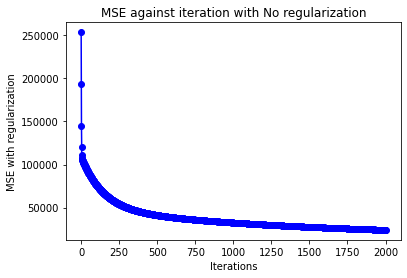

In [21]:
(weights, bias, df_plot_values) = train_model(X_train, y_train, num_epochs=2000, learning_rate=0.00000001, lambda_val=0.01, regularization_component=Regularization.No_regularization)
plt.plot(df_plot_values['epoch'], df_plot_values['MSE'], marker='o', color='blue')
plt.title("MSE against iteration with No regularization")
plt.xlabel("Iterations")
plt.ylabel("MSE with regularization")
plt.show()
final_output.append(("No_regularization", *weights))

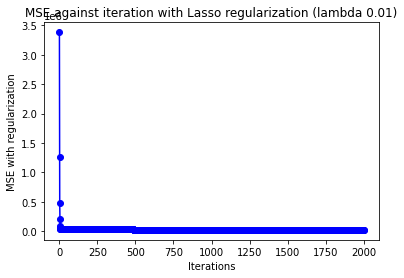

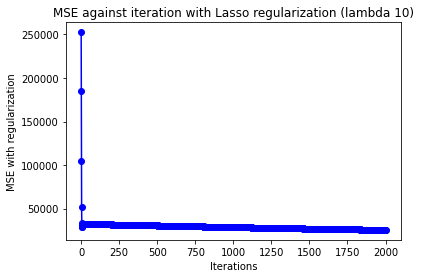

In [22]:
(weights, bias, df_plot_values) = train_model(X_train, y_train, num_epochs=2000, learning_rate=0.00000001, lambda_val=0.01, regularization_component=Regularization.Lasso)
plt.plot(df_plot_values['epoch'], df_plot_values['MSE'], marker='o', color='blue')
plt.title("MSE against iteration with Lasso regularization (lambda 0.01)")
plt.xlabel("Iterations")
plt.ylabel("MSE with regularization")
plt.show()
final_output.append(("Lasso_regularization_with_lambda_0.01", *weights))
(weights, bias, df_plot_values) = train_model(X_train, y_train, num_epochs=2000, learning_rate=0.00000001, lambda_val=10, regularization_component=Regularization.Lasso)
plt.plot(df_plot_values['epoch'], df_plot_values['MSE'], marker='o', color='blue')
plt.title("MSE against iteration with Lasso regularization (lambda 10)")
plt.xlabel("Iterations")
plt.ylabel("MSE with regularization")
plt.show()
final_output.append(("Lasso_regularization_with_lambda_10", *weights))

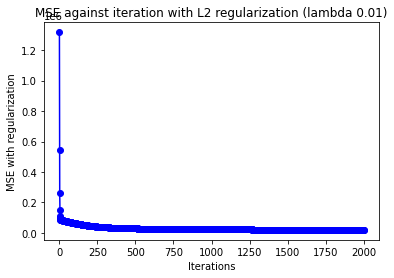

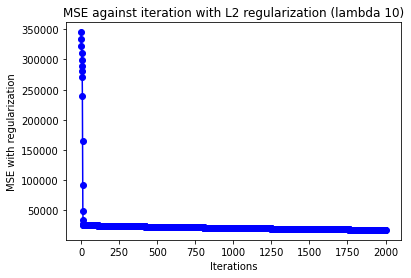

In [23]:
(weights, bias, df_plot_values) = train_model(X_train, y_train, num_epochs=2000, learning_rate=0.00000001, lambda_val=0.01, regularization_component=Regularization.L2)
plt.plot(df_plot_values['epoch'], df_plot_values['MSE'], marker='o', color='blue')
plt.title("MSE against iteration with L2 regularization (lambda 0.01)")
plt.xlabel("Iterations")
plt.ylabel("MSE with regularization")
plt.show()
final_output.append(("L2_regularization_with_lambda_0.01", *weights))
(weights, bias, df_plot_values) = train_model(X_train, y_train, num_epochs=2000, learning_rate=0.00000001, lambda_val=10, regularization_component=Regularization.L2)
plt.plot(df_plot_values['epoch'], df_plot_values['MSE'], marker='o', color='blue')
plt.title("MSE against iteration with L2 regularization (lambda 10)")
plt.xlabel("Iterations")
plt.ylabel("MSE with regularization")
plt.show()
final_output.append(("L2_regularization_with_lambda_10", *weights))

In [24]:
df_output = pd.DataFrame(final_output, columns=["Regularization", *X_train.columns.values])
df_output

,Regularization,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_is_A,League_is_N,Division_is_E,Division_is_W,NewLeague_A,NewLeague_N
0,No_regularization,0.551991,-0.449282,-0.093335,-0.047301,0.290383,-0.515897,-0.129045,0.092401,0.151376,-0.351593,-0.195774,-0.355110,0.086098,0.141576,0.057182,-0.148651,-0.201783,0.597151,0.163052,0.074151,-0.343053,-0.345824
1,Lasso_regularization_with_lambda_0.01,-0.104252,-0.104136,0.258885,0.360895,-0.478853,-0.027769,0.498624,0.131253,0.105402,-0.003283,-0.256057,-0.371715,-0.007686,0.535865,0.472574,0.147116,-0.109381,-0.237824,-0.345627,-0.467526,0.439902,-0.230146
2,Lasso_regularization_with_lambda_10,0.432239,-0.524801,-0.492910,-0.106202,0.483225,-0.550877,-0.313738,0.085144,0.077749,-0.541676,0.019246,-0.386616,0.231946,0.408471,0.171083,0.456342,0.252517,-0.399830,-0.170783,-0.310773,-0.420183,0.382506
3,L2_regularization_with_lambda_0.01,0.036080,0.317754,0.563415,0.218691,-0.082268,-0.441445,0.052109,0.194648,-0.180236,-0.704454,0.370659,-0.693328,-0.072138,-0.051628,0.362534,0.341840,0.319929,-0.224284,0.434958,-0.404128,-0.598555,-0.521214
4,L2_regularization_with_lambda_10,0.047325,0.096605,0.210080,0.195353,-0.113490,-0.304196,0.198121,0.212828,-0.092694,-0.349686,-0.080833,-0.620906,-0.084317,0.260053,0.294769,0.525751,-0.517864,0.548518,0.476746,0.311844,0.250535,-0.237942
